In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/train.csv")
test = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/test.csv")
sample = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/sample_submission.csv")

In [ ]:
train.head()

In [ ]:
train.isnull().sum()

In [ ]:
duplicate_train = train[train.duplicated()]

In [ ]:
duplicate_train

In [ ]:
train.info()

In [ ]:
sns.distplot(train['age'])

In [ ]:
object_col = []

for column in train.columns:
    if train[column].dtype == object and len(train[column].unique()) <=30:
        object_col.append (column)
        print (f"{column} : {train[column].unique()}")
        print (train[column].value_counts())
        print ("================")

In [ ]:
train.isnull().sum()

In [ ]:
train['education'].value_counts()

In [3]:
train['education'] = train['education'].fillna("Bachelor's")

In [ ]:
train['previous_year_rating'].value_counts()

In [ ]:
sns.distplot(train['previous_year_rating'])

In [4]:
train['previous_year_rating'] = train['previous_year_rating'].fillna(3.0)

In [ ]:
train.head()

In [ ]:
test.isnull().sum()

In [5]:
test['education'] = test['education'].fillna("Bachelor's")
test['previous_year_rating'] = test['previous_year_rating'].fillna(3.0)

In [ ]:
test['previous_year_rating'].value_counts()

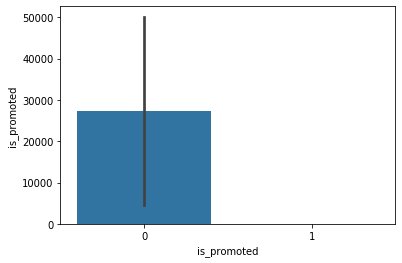

In [6]:
sns.barplot(train['is_promoted'],train['is_promoted'].value_counts())

In [ ]:
train['is_promoted'].value_counts()

In [ ]:
train.shape

## Performing LGBM:

In [7]:
train=train.drop_duplicates(subset=[ele for ele in list(train.columns) if ele not in ['employee_id']])

In [8]:
train.shape

(54647, 14)

In [9]:
combine_set=pd.concat([train,test], ignore_index=True)

In [ ]:
combine_set.shape

In [ ]:
combine_set.head()

In [10]:
le=LabelEncoder()

In [11]:
combine_set['gender']=le.fit_transform(combine_set['gender'])
combine_set['department']=le.fit_transform(combine_set['department'])
#combine_set['recruitment_channel']=le.fit_transform(combine_set['recruitment_channel'])

In [ ]:
combine_set['education'].value_counts()

In [12]:
combine_set['education']=combine_set['education'].map({'Below Secondary':1,"Bachelor's":2,"Master's & above":3})

In [ ]:
combine_set.tail()

In [13]:
combine_set[['region1','region']] =  combine_set['region'].str.split("_", expand = True)

In [14]:
combine_set.drop(['region1'], axis = 1, inplace = True)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(combine_set.corr(),annot=True,fmt=".2f")

In [15]:
combine_set['previous_year_rating'] = combine_set['previous_year_rating'].astype('int')

In [16]:
combine_set['Total_Score'] = combine_set['no_of_trainings'] * combine_set['avg_training_score']

In [17]:
combine_set['departmentwise_rating_sum']=combine_set.groupby(['department'])['previous_year_rating'].transform('sum')
#combine_set['departmentwise_rating_SD']=combine_set.groupby(['department'])['previous_year_rating'].transform('std')
#combine_set['departmentwise_rating_uni']=combine_set.groupby(['department'])['previous_year_rating'].transform('nunique')


combine_set['recruitment_rating_sum']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('sum')
#combine_set['recruitment_rating_SD']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('std')
#combine_set['recruitment_rating_uni']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('nunique')

In [ ]:
#combine_set['departmentwise_rating_mod']=combine_set.groupby(['department'])['previous_year_rating'].agg(lambda x:x.value_counts().index[0])

In [ ]:
combine_set.head()

In [18]:
combine_set['education_rating_sum']=combine_set.groupby(['education'])['previous_year_rating'].transform('sum')
#combine_set['education_rating_SD']=combine_set.groupby(['education'])['previous_year_rating'].transform('std')
#combine_set['education_rating_uni']=combine_set.groupby(['education'])['previous_year_rating'].transform('nunique')

In [19]:
combine_set['awards_won_rating_sum']=combine_set.groupby(['awards_won?'])['previous_year_rating'].transform('sum')
#combine_set['service_length_rating_sd']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('std')
#combine_set['service_length_rating_nuq']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('nunique')

In [ ]:
sns.boxplot(combine_set['age'])

In [20]:
combine_set['service_length_rating_sum']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('sum')
#combine_set['service_length_rating_sd']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('std')
#combine_set['service_length_rating_uni']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('nunique')

In [21]:
combine_set['age_service_length_rating_sum']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('sum')
#combine_set['age_service_length_rating_sd']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('std')
#combine_set['age_service_length_rating_uni']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('nunique')

In [22]:
combine_set['region_rating_sum']=combine_set.groupby(['region'])['previous_year_rating'].transform('sum')
#combine_set['region_rating_SD']=combine_set.groupby(['region'])['previous_year_rating'].transform('std')
#combine_set['region_rating_uni']=combine_set.groupby(['region'])['previous_year_rating'].transform('nunique')

In [23]:
combine_set['KPI_rating_sum']=combine_set.groupby(['KPIs_met >80%'])['previous_year_rating'].transform('sum')
#combine_set['KPI_rating_SD']=combine_set.groupby(['KPIs_met >80%'])['previous_year_rating'].transform('std')
#combine_set['KPI_rating_uni']=combine_set.groupby(['KPIs_met >80%'])['previous_year_rating'].transform('nunique')

In [ ]:
pd.set_option('display.max_columns', None)
combine_set.head()

In [ ]:
combine_set.shape

In [ ]:
combine_set['age_service_length_rating_uni'].value_counts()

In [24]:
from sklearn.preprocessing import KBinsDiscretizer

In [25]:
age_discretizer = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')

In [26]:
combine_set['Age_Bins'] =age_discretizer.fit_transform(combine_set['age'].values.reshape(-1,1)).astype(int)

In [27]:
train_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
service_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [28]:
combine_set['train_score_Bins'] =train_discretizer.fit_transform(combine_set['avg_training_score'].values.reshape(-1,1)).astype(int)
combine_set['service_Bins'] =service_discretizer.fit_transform(combine_set['length_of_service'].values.reshape(-1,1)).astype(int)

In [ ]:
combine_set.head()

In [29]:
region_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
combine_set['region'] =region_discretizer.fit_transform(combine_set['region'].values.reshape(-1,1)).astype(int)

In [ ]:
combine_set.isnull().sum()

In [30]:
recruite_counts = combine_set['recruitment_channel'].value_counts().to_dict()

In [31]:
combine_set['recruitment_channel'] = combine_set['recruitment_channel'].map(recruite_counts)

In [ ]:
combine_set.head()

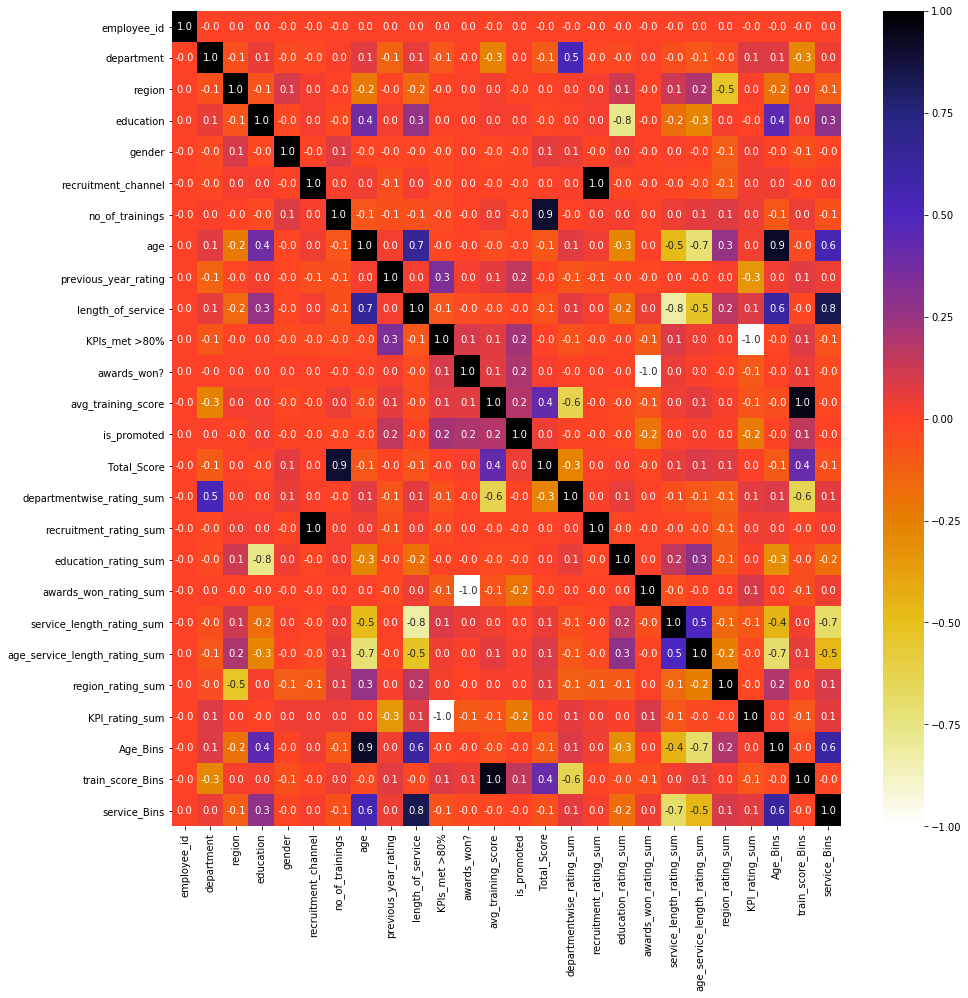

In [33]:
plt.figure(figsize=(15,15))
sns.heatmap(combine_set.corr(),annot=True,fmt=".1f",cmap=plt.cm.CMRmap_r)

In [34]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(combine_set, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = combine_set.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [37]:
corr_features = correlation(combine_set, 0.8)
len(set(corr_features))

5

In [38]:
corr_features

{'Age_Bins',
 'Total_Score',
 'recruitment_rating_sum',
 'service_Bins',
 'train_score_Bins'}

In [ ]:
combine_set['is_promoted'].value_counts()

In [ ]:
combine_set.head()

In [39]:
train_df=combine_set[combine_set['is_promoted'].isnull()==False]
test_df=combine_set[combine_set['is_promoted'].isnull()==True]

In [40]:
X=train_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)
y=train_df['is_promoted']

X_main_test=test_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)

In [44]:
#Kfold
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
pred_score=0
preds=0

In [ ]:
X.info()

## Light GBM:

In [45]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
gbm = lgb.LGBMClassifier()

In [46]:
for i, (train_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    hyper_params = {
    "learning_rate":[0.05,0.1,0.15,0.2,0.25],
    "max_depth":[3,4,5,7,9,10,15,20],
    "min_data_in_leaf":[10,20,25,30],
    "lambda" : [0,0.01, 0.05, 0.1 ,0.2, 0.5, 0.8]   
    #"colsample_bytree":[0.3,0.4,0.5,0.6],
    "num_leaves " : [10,20,30,40,50,100],
    "eval_metric" : ['auc'],
    "num_leaves":[10,20,30,50,100],
    "boosting" : ['gbdt','goss'],
    #"n_estimators" : [100, 500, 900, 1100, 1500]
}
    
    random_search = RandomizedSearchCV(gbm,param_distributions = hyper_params,
                                  n_iter = 50,
                                  n_jobs = -1,cv = 5, verbose = 50)
    
    #lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,
     #                 learning_rate=0.04,objective='binary',metric='auc',
      #                colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,
       #               random_state=294,n_jobs=-1)      
   

    random_search.fit(X_train,y_train)
    print(roc_auc_score(y_val,random_search.predict_proba(X_val)[:,1]))
    
    pred_score=roc_auc_score(y_val,random_search.predict_proba(X_val)[:,1])
    
    preds=random_search.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}'.format(pred_score/10))

#preds_random_search=preds/10



Fold: 1

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | e

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Paralle

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   24.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 159 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.9min
[Paralle

[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   32.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 171 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Paralle

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   49.5s
[Paralle

[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:  2.3min
[Paralle

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:  2.6min
[Paralle

In [47]:
preds

array([1.50690398e-01, 1.49346789e-03, 5.49983504e-04, ...,
       5.85787695e-04, 2.49010977e-03, 9.05063617e-01])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print(confusion_matrix(y_val,preds))
print(accuracy_score(y_val,preds))
print(classification_report(y_val, preds))

## XGBoost:

In [ ]:
#Kfold
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
pred_score=0
preds=0

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [ ]:
clf = xgboost.XGBClassifier()

In [ ]:
for i, (train_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    params = {
    "n_estimators" : [10, 50, 90,100,200],
    "max_depth" : [2, 3, 5, 10, 15,20,30],
    "booster": ['gbtree'],
    "learning_rate":[0.05,0.1,0.15,0.20,0.3],
    "min_child_weight":[1,2,3,4,5,10],
    "eval_metric": ['auc'],
    "gamma" : [0,0.01,0.02,0.1,0.2,0.3,0.05],
    #"scale_pos_weight ": [7] ## For imbalance data ([0]/[1]= 7 ,8,)
}
    
    # Set up the random search with 4-fold cross validation
    random_cv = RandomizedSearchCV(estimator=clf,
            param_distributions=params,
            cv=5,
            n_iter=10,
            n_jobs = -1,
            verbose = 50, 
            random_state=42,
            return_train_score = False) 
    #lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,
     #                 learning_rate=0.04,objective='binary',metric='auc',
      #                colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,
       #               random_state=294,n_jobs=-1)      
   

    random_cv.fit(X_train,y_train)
    print(roc_auc_score(y_val,random_cv.predict_proba(X_val)[:,1]))
    #print(roc_auc_score(y_val,random_cv.predict(X_val)[:,1]))
    
    pred_score_XG = roc_auc_score(y_val,random_cv.predict_proba(X_val)[:,1])
    #pred_score_XG = roc_auc_score(y_val,random_cv.predict(X_val)[:,1])
    
    preds_XG = random_cv.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}',np.mean(preds_XG))

#preds_random_search_XG=preds_XG/10


In [ ]:
preds_XG

In [ ]:
sample.head()

In [ ]:
#Submission File
sample['is_promoted1']=preds*0.3+preds_XG*0.7 #50% 
sample['is_promoted2']=preds*0.4+preds_XG*0.6
sample['is_promoted3']=preds*0.5+preds_XG*0.5
sample['is_promoted4']=preds*0.2+preds_XG*0.8

#sample.to_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/main_test.csv',index=False)
sample.head(15)


In [ ]:
sample['is_promoted5']=preds*0.33+preds_XG*0.77
sample['is_promoted6']=preds*0.25+preds_XG*0.75
    
#sample['is_promoted5']=np.where(sample['is_promoted5']>=1,1,0)
#sample['is_promoted6']=np.where(sample['is_promoted6']>=1,1,0)
    
    

In [ ]:
sample.head(15)

In [ ]:
sample.to_csv("C:/Users/Aditya/Desktop/HR Analytics/LGBM_XGB-bend3.csv",index=False)

In [ ]:
sample['is_promoted11']=np.where(sample['is_promoted1']>=0.8,1,0)
sample['is_promoted22']=np.where(sample['is_promoted2']>=0.7,1,0)
sample['is_promoted33']=np.where(sample['is_promoted3']>=6,1,0)
sample['is_promoted44']=np.where(sample['is_promoted4']>=65,1,0)


In [ ]:
sample['is_promoted33'].value_counts()
#sample['is_promoted2'].value_counts()
#sample['is_promoted3'].value_counts()
#sample['is_promoted4'].value_counts()
#sample['is_promoted4'].value_counts()
#sample['is_promoted5'].value_counts()
#sample['is_promoted6'].value_counts()

In [ ]:
sample.head(15)

## CatBoost:

In [48]:
train_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,...,recruitment_rating_sum,education_rating_sum,awards_won_rating_sum,service_length_rating_sum,age_service_length_rating_sum,region_rating_sum,KPI_rating_sum,Age_Bins,train_score_Bins,service_Bins
0,65438,7,1,3,0,33111,1,35,5,8,...,109341,72021,252093,13827,1691,23021,106869,4,0,4
1,65141,4,3,2,1,43434,1,30,5,4,...,142948,182545,252093,32384,3121,30547,151572,2,2,2
2,7513,7,3,2,1,33111,1,34,3,7,...,109341,182545,252093,26336,2903,4269,151572,4,1,3
3,2542,7,3,2,1,43434,2,39,1,10,...,142948,182545,252093,10464,977,5695,151572,5,1,4
4,48945,8,4,2,1,43434,1,45,3,2,...,142948,182545,252093,31628,120,10680,151572,6,3,1


In [49]:
cat_col=['department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','previous_year_rating']

In [50]:
train_df=combine_set[combine_set['is_promoted'].isnull()==False]
test_df=combine_set[combine_set['is_promoted'].isnull()==True]

In [51]:
#X=train_df.drop(['employee_id','is_promoted','age_service_length_rating','recruitment_rating',
#                 'education_rating','awards_won_rating'],axis=1)

X_cat=train_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)

y=train_df['is_promoted']

#X_main_test=test_df.drop(['employee_id','is_promoted','age_service_length_rating','recruitment_rating',
 #                'education_rating','awards_won_rating'],axis=1)


X_main_test=test_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)


In [52]:
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=294)
predictions=[]
test_roc_score=[]

In [53]:
for i,(train_idx,val_idx) in enumerate(kf.split(X_cat,y)):    

    X_train, y_train = X_cat.iloc[train_idx,:], y.iloc[train_idx]

    X_val, y_val = X_cat.iloc[val_idx, :], y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    classifier = CatBoostClassifier(learning_rate = 0.055,random_state=42,scale_pos_weight=7, custom_metric=['AUC'])

    classifier.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    
    testpred = classifier.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred))
    print("Test ROC AUC : %.4f"%(roc_auc_score(y_val, testpred)))
    predictions.append(classifier.predict_proba(X_main_test)[:,1])

print("Mean test score:",np.mean(test_roc_score))
preds_cb=np.mean(predictions,axis=0)


Fold: 1

0:	learn: 0.6546052	test: 0.6546272	best: 0.6546272 (0)	total: 586ms	remaining: 9m 45s
100:	learn: 0.3626060	test: 0.3734172	best: 0.3734172 (100)	total: 14s	remaining: 2m 5s
200:	learn: 0.3388773	test: 0.3592846	best: 0.3592846 (200)	total: 28s	remaining: 1m 51s
300:	learn: 0.3179772	test: 0.3510665	best: 0.3507897 (284)	total: 43.8s	remaining: 1m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3505397402
bestIteration = 310

Shrink model to first 311 iterations.
Test ROC AUC : 0.9052

Fold: 2

0:	learn: 0.6487642	test: 0.6487755	best: 0.6487755 (0)	total: 204ms	remaining: 3m 23s
100:	learn: 0.3597585	test: 0.3642474	best: 0.3642474 (100)	total: 13.5s	remaining: 2m
200:	learn: 0.3399908	test: 0.3487346	best: 0.3487346 (200)	total: 27s	remaining: 1m 47s
300:	learn: 0.3204785	test: 0.3410423	best: 0.3409303 (295)	total: 42.9s	remaining: 1m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3384178373
bestIteration = 343

Shrink mode

In [54]:
preds_cb

array([5.35775727e-01, 5.25888033e-03, 4.10279611e-04, ...,
       3.21980230e-03, 3.08328308e-02, 9.41576647e-01])

In [55]:
sample.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [57]:
#Submission File
sample['is_promoted1']=preds*0.3+preds_cb*0.7 #50% 
sample['is_promoted2']=preds*0.4+preds_cb*0.6
sample['is_promoted3']=preds*0.5+preds_cb*0.5
sample['is_promoted4']=preds*0.2+preds_cb*0.8


sample['is_promoted11']=preds*0.7+preds_cb*0.3 #50% 
sample['is_promoted22']=preds*0.6+preds_cb*0.4
sample['is_promoted33']=preds*0.4+preds_cb*0.6
sample['is_promoted44']=preds*0.3+preds_cb*0.7


#sample.to_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/main_test.csv',index=False)
sample.head(15)


,employee_id,is_promoted,is_promoted1,is_promoted2,is_promoted3,is_promoted4,is_promoted11,is_promoted22,is_promoted33,is_promoted44
0,8724,0,0.420250,0.381742,0.343233,0.458759,0.266216,0.304725,0.381742,0.420250
1,74430,0,0.004129,0.003753,0.003376,0.004506,0.002623,0.003000,0.003753,0.004129
2,72255,0,0.000452,0.000466,0.000480,0.000438,0.000508,0.000494,0.000466,0.000452
3,38562,0,0.005396,0.004928,0.004461,0.005864,0.003526,0.003993,0.004928,0.005396
4,64486,0,0.014753,0.012831,0.010908,0.016676,0.007063,0.008986,0.012831,0.014753
5,46232,0,0.023240,0.020312,0.017383,0.026169,0.011526,0.014454,0.020312,0.023240
6,54542,0,0.268487,0.241558,0.214628,0.295417,0.160768,0.187698,0.241558,0.268487
7,67269,0,0.103712,0.092656,0.081600,0.114768,0.059488,0.070544,0.092656,0.103712
8,66174,0,0.017533,0.015626,0.013718,0.019441,0.009903,0.011811,0.015626,0.017533
9,76303,0,0.599386,0.550034,0.500683,0.648737,0.401980,0.451332,0.550034,0.599386


In [58]:
sample.to_csv("C:/Users/Aditya/Desktop/HR Analytics/LGB_CatBoost-1.csv",index=False)